In [1]:
import yfinance as yf

In [98]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
data_df = yf.download("AAPL", start="2015-02-01", end="2020-03-20")

[*********************100%***********************]  1 of 1 completed


In [5]:
df = data_df.reset_index()

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-02,118.050003,119.169998,116.080002,118.629997,108.447662,62739100
1,2015-02-03,118.500000,119.089996,117.610001,118.650002,108.465935,51915700
2,2015-02-04,118.500000,120.510002,118.309998,119.559998,109.297836,70149700
3,2015-02-05,120.019997,120.230003,119.250000,119.940002,110.077942,42246200
4,2015-02-06,120.019997,120.250000,118.449997,118.930000,109.150978,43706600


In [83]:
series = np.array(df['Close'])
series = MinMaxScaler().fit_transform(series.reshape(-1, 1)).flatten()
T = 10
X = []
y = []

for t in range(len(df) - T):
    X.append(series[t:t+T])
    y.append(series[t+T])

In [84]:
X = np.expand_dims(np.array(X), -1)
y = np.array(y)

In [85]:
X.shape, y.shape

((1282, 10, 1), (1282,))

In [94]:
i = tf.keras.layers.Input(shape=(X[0].shape))
j = tf.keras.layers.LSTM(10)(i)
j = tf.keras.layers.Dense(1)(j)

model = tf.keras.models.Model(i, j)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1), loss='mse')

In [95]:
N = len(X)
r = model.fit(X[:N//2], y[:N//2], validation_data = [X[N//2:], y[N//2:]], epochs=60)

Train on 641 samples, validate on 641 samples
Epoch 1/60
641/641 [==============================] - 15s 23ms/sample - loss: 0.0423 - val_loss: 0.1833
Epoch 2/60
641/641 [==============================] - 1s 2ms/sample - loss: 0.0057 - val_loss: 0.1370
Epoch 3/60
641/641 [==============================] - 1s 2ms/sample - loss: 0.0036 - val_loss: 0.0771
Epoch 4/60
641/641 [==============================] - 1s 2ms/sample - loss: 0.0011 - val_loss: 0.0194
Epoch 5/60
641/641 [==============================] - 2s 3ms/sample - loss: 3.0199e-04 - val_loss: 0.0218
Epoch 6/60
641/641 [==============================] - 2s 2ms/sample - loss: 1.9384e-04 - val_loss: 0.0146
Epoch 7/60
641/641 [==============================] - 2s 3ms/sample - loss: 2.2256e-04 - val_loss: 0.0127
Epoch 8/60
641/641 [==============================] - 2s 3ms/sample - loss: 9.5609e-05 - val_loss: 0.0112
Epoch 9/60
641/641 [==============================] - 1s 2ms/sample - loss: 1.1626e-04 - val_loss: 0.0091
Epoch 10/60
64

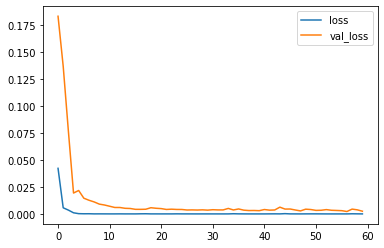

In [96]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

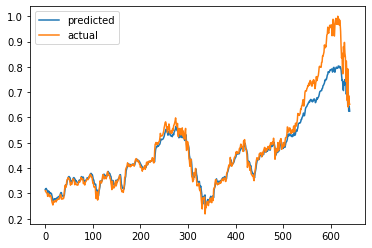

In [97]:
#One-step preeiction

y_hat = model.predict(X[N//2:])
plt.plot(y_hat, label='predicted')
plt.plot(y[N//2:], label='actual')
plt.legend()
plt.show()

In [101]:
np.sqrt(mean_squared_error(y_hat, y[N//2:]))

0.05063666465843004

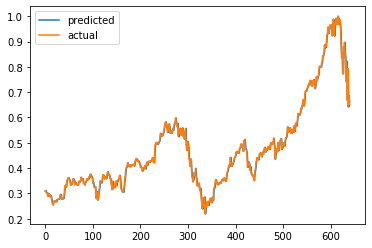

In [102]:
# Naive predictor

y_hat = y[(N//2 - 1):-1]
plt.plot(y_hat, label='predicted')
plt.plot(y[N//2:], label='actual')
plt.legend()
plt.show()

In [103]:
np.sqrt(mean_squared_error(y_hat, y[N//2:]))

0.018695161385667642

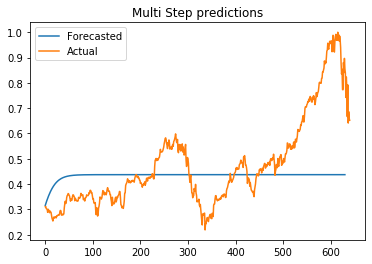

In [104]:
# Mult-step prediction

y_hat = []

X_useful = series[N//2 : N//2+T]

for i in range(N//2-T):
    x_last = model.predict(X_useful[i:i+10].reshape(1, 10, 1))[0, 0]
    y_hat.append(x_last)
    X_useful = np.append(X_useful, x_last)
    

plt.plot(y_hat, label='Forecasted')
plt.plot(y[N//2:], label='Actual')
plt.legend()
plt.title('Multi Step predictions')
plt.show()

In [105]:
df['previous_close'] = df['Close'].shift(1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,previous_close
0,2015-02-02,118.050003,119.169998,116.080002,118.629997,108.447662,62739100,NaN
1,2015-02-03,118.500000,119.089996,117.610001,118.650002,108.465935,51915700,118.629997
2,2015-02-04,118.500000,120.510002,118.309998,119.559998,109.297836,70149700,118.650002
3,2015-02-05,120.019997,120.230003,119.250000,119.940002,110.077942,42246200,119.559998
4,2015-02-06,120.019997,120.250000,118.449997,118.930000,109.150978,43706600,119.940002


In [108]:
df['return'] = (df['Close'] - df['previous_close']) *100 / df['previous_close']

In [111]:
df = df.dropna()

In [114]:
series = np.array(df['return'])
series = MinMaxScaler().fit_transform(series.reshape(-1, 1)).flatten()
T = 10
X = []
y = []

for t in range(len(df) - T):
    X.append(series[t:t+T])
    y.append(series[t+T])

In [115]:
X = np.expand_dims(np.array(X), -1)
y = np.array(y)
N = len(X)

i = tf.keras.layers.Input(shape=(X[0].shape))
j = tf.keras.layers.LSTM(10)(i)
j = tf.keras.layers.Dense(1)(j)

model = tf.keras.models.Model(i, j)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1), loss='mse')

r = model.fit(X[:N//2], y[:N//2], validation_data = [X[N//2:], y[N//2:]], epochs=60)

Train on 640 samples, validate on 641 samples
Epoch 1/60
640/640 [==============================] - 16s 24ms/sample - loss: 0.0557 - val_loss: 0.0081
Epoch 2/60
640/640 [==============================] - 2s 3ms/sample - loss: 0.0037 - val_loss: 0.0064
Epoch 3/60
640/640 [==============================] - 2s 3ms/sample - loss: 0.0036 - val_loss: 0.0065
Epoch 4/60
640/640 [==============================] - 2s 2ms/sample - loss: 0.0034 - val_loss: 0.0063
Epoch 5/60
640/640 [==============================] - 2s 3ms/sample - loss: 0.0036 - val_loss: 0.0063
Epoch 6/60
640/640 [==============================] - 2s 4ms/sample - loss: 0.0035 - val_loss: 0.0063
Epoch 7/60
640/640 [==============================] - 2s 3ms/sample - loss: 0.0036 - val_loss: 0.0063
Epoch 8/60
640/640 [==============================] - 2s 2ms/sample - loss: 0.0039 - val_loss: 0.0064
Epoch 9/60
640/640 [==============================] - 2s 3ms/sample - loss: 0.0036 - val_loss: 0.0063
Epoch 10/60
640/640 [=============

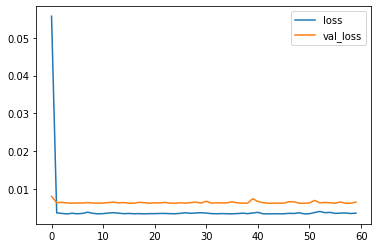

In [116]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

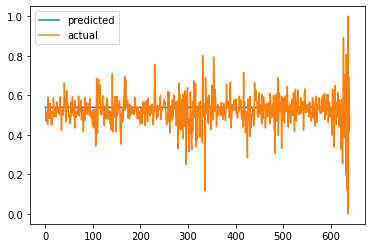

In [117]:
#One-step preeiction

y_hat = model.predict(X[N//2:])
plt.plot(y_hat, label='predicted')
plt.plot(y[N//2:], label='actual')
plt.legend()
plt.show()

In [118]:
np.sqrt(mean_squared_error(y_hat, y[N//2:]))

0.08101776959985624

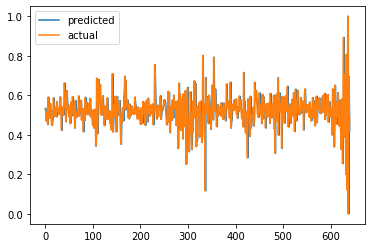

In [119]:
# Naive predictor

y_hat = y[(N//2 - 1):-1]
plt.plot(y_hat, label='predicted')
plt.plot(y[N//2:], label='actual')
plt.legend()
plt.show()

In [120]:
np.sqrt(mean_squared_error(y_hat, y[N//2:]))

0.12114098234185765

In [169]:
df['trend'] = np.sign(df['return']) 
df['trend'] = df['trend'].map({-1:0, 1:1, 0:0})

In [173]:
df = df.drop(columns=['Date', 'Adj Close', 'previous_close', 'return'])

In [175]:
df['future_trend'] = df['trend'].shift(1)

In [179]:
df.dropna(inplace=True)
df.drop(columns=['trend'], inplace=True)
df['future_trend'] = df['future_trend'].apply(lambda x: int(x))

In [180]:
df

,Open,High,Low,Close,Volume,future_trend
2,118.500000,120.510002,118.309998,119.559998,70149700,1
3,120.019997,120.230003,119.250000,119.940002,42246200,1
4,120.019997,120.250000,118.449997,118.930000,43706600,1
5,118.550003,119.839996,118.430000,119.720001,38889800,0
6,120.169998,122.150002,120.160004,122.019997,62008500,1
...,...,...,...,...,...,...
1287,264.890015,279.920013,252.949997,277.970001,92683000,0
1288,241.949997,259.079987,240.000000,242.210007,80605900,1
1289,247.509995,257.609985,238.399994,252.860001,81014000,0
1290,239.770004,250.000000,237.119995,246.669998,75058400,1


In [187]:
X = scaler.fit_transform(df.iloc[:, :-1])
y = np.array(df['future_trend'])

In [200]:
i = tf.keras.layers.Input(shape=(X.shape[1],))
j = tf.keras.layers.Dense(10, activation='relu')(i)
j = tf.keras.layers.Dropout(0.3)(j)
j = tf.keras.layers.Dense(1, activation = 'sigmoid')(j)

model = tf.keras.models.Model(i, j)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=['binary_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                60        
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [201]:
N = X.shape[0]
r = model.fit(X[:N//2], y[:N//2], validation_data=(X[N//2:], y[N//2:]), epochs=10)

Train on 645 samples, validate on 645 samples
Epoch 1/10
645/645 [==============================] - 4s 7ms/sample - loss: 0.7487 - accuracy: 0.4853 - val_loss: 0.7357 - val_accuracy: 0.4543
Epoch 2/10
645/645 [==============================] - 1s 1ms/sample - loss: 0.7105 - accuracy: 0.5070 - val_loss: 0.7137 - val_accuracy: 0.4589
Epoch 3/10
645/645 [==============================] - 1s 1ms/sample - loss: 0.6953 - accuracy: 0.5147 - val_loss: 0.7024 - val_accuracy: 0.4558
Epoch 4/10
645/645 [==============================] - 1s 1ms/sample - loss: 0.6945 - accuracy: 0.5318 - val_loss: 0.6942 - val_accuracy: 0.5023
Epoch 5/10
645/645 [==============================] - 1s 1ms/sample - loss: 0.6926 - accuracy: 0.5209 - val_loss: 0.6924 - val_accuracy: 0.5333
Epoch 6/10
645/645 [==============================] - 1s 865us/sample - loss: 0.6926 - accuracy: 0.5271 - val_loss: 0.6906 - val_accuracy: 0.5364
Epoch 7/10
645/645 [==============================] - 1s 1ms/sample - loss: 0.6869 - acc

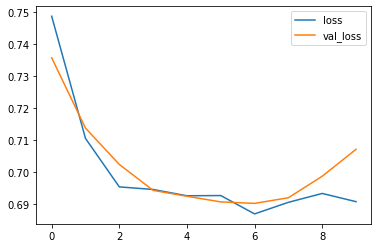

In [202]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

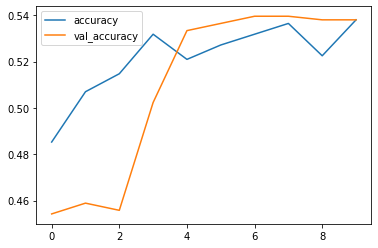

In [203]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [208]:
model.evaluate(X[N//2:], y[N//2:], verbose='quiet')

[0.7070948842884034, 0.5379845]

In [222]:
# Naive predictor

y_hat = np.random.choice([0, 1], N//2)
(y_hat == y[N//2:]).astype(int).sum() / (N//2)

0.5224806201550387